In [72]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchsample
import psycopg2
import random
import re
import time
import csv
import copy

from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import models
from torchvision import transforms
from torchsample import transforms as ts_transforms
from datetime import datetime as dt

from matplotlib import pyplot as plt
from PIL import Image
from scipy.ndimage import imread
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor

from mpl_toolkits.mplot3d import Axes3D
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [13]:
schiphol_df = main_df[main_df['MeteoStationLocationID'] == 542]
schiphol_highways = schiphol_df[schiphol_df['location_name']!= 'SCHIPHOL airport']
eelde_df = main_df[main_df['MeteoStationLocationID'] == 506]
eelde_highways = eelde_df[eelde_df['location_name'] != 'EELDE airport']
highway_df = pd.concat([eelde_highways, schiphol_highways])
highway_df = highway_df[highway_df['distanceInMeters'] < 7500]

In [34]:
unique = highway_df.drop_duplicates(['camera_name', 'distanceInMeters'])

In [93]:
cam_dict = {}

for idx, row in unique.iterrows():   
    cam_dict[row['camera_name']] = {'total_count': 0, '1-to-2': 0, '1-to-0': 0, '2-to-1': 0, '2-to-0': 0,
                                    'distance': row['distanceInMeters']}

In [96]:
relabel_dict = {'1-to-0': 0, '1-to-2': 0, '2-to-0': 0, '2-to-1':0}

with open('../data/helpers/trainhighwaylabels') as file:
    for i,row in enumerate(file):

        path, new_target = row.split(',')
        regex = re.compile(r'ID\d*')
        search = re.search(regex, path)
        ID = search.group(0)
        cam_dict[ID]['total_count'] +=1
        
        regex = re.compile(r'_\d*_\d*.')
        search = re.search(regex, path)
        date = search.group(0)[1:-1]
        
        datetime = dt.strptime(date, '%Y%m%d_%H%M')
        dfrow = main_df[(main_df['datetime'] == datetime) & (main_df['camera_name'] == ID)]
        original_target =int(list(dfrow['visibility'])[0])
        new_target = int(new_target)
        if original_target == 1:
            if new_target == 0:
                cam_dict[ID]['1-to-0'] += 1
                relabel_dict['1-to-0'] +=1
            elif new_target == 2:
                cam_dict[ID]['1-to-2'] += 1
                relabel_dict['1-to-2'] += 1
                
        elif original_target == 2:
            if new_target == 0:
                cam_dict[ID]['2-to-0'] += 1
                relabel_dict['2-to-0'] += 1
            elif new_target == 1:
                cam_dict[ID]['2-to-1'] += 1 
                relabel_dict['2-to-1'] += 1
    
    file.close()

In [95]:
counts, distances = [], []

for key, values in cam_dict.items():
    counts.append(values['total_count'])
    distances.append(values['distance'])

{'ID11039': {'1-to-0': 9,
  '1-to-2': 18,
  '2-to-0': 1,
  '2-to-1': 6,
  'distance': 4850.7713037373605,
  'total_count': 36},
 'ID11043': {'1-to-0': 8,
  '1-to-2': 9,
  '2-to-0': 3,
  '2-to-1': 46,
  'distance': 1218.56392928257,
  'total_count': 66},
 'ID11044': {'1-to-0': 7,
  '1-to-2': 34,
  '2-to-0': 1,
  '2-to-1': 2,
  'distance': 3793.7970235204707,
  'total_count': 44},
 'ID11064': {'1-to-0': 8,
  '1-to-2': 1,
  '2-to-0': 1,
  '2-to-1': 18,
  'distance': 1704.7123746289099,
  'total_count': 28},
 'ID11065': {'1-to-0': 22,
  '1-to-2': 0,
  '2-to-0': 2,
  '2-to-1': 13,
  'distance': 2922.50535848398,
  'total_count': 37},
 'ID11066': {'1-to-0': 8,
  '1-to-2': 14,
  '2-to-0': 0,
  '2-to-1': 16,
  'distance': 2983.88651823776,
  'total_count': 40},
 'ID11083': {'1-to-0': 0,
  '1-to-2': 30,
  '2-to-0': 0,
  '2-to-1': 2,
  'distance': 4843.21696793511,
  'total_count': 32},
 'ID11087': {'1-to-0': 0,
  '1-to-2': 0,
  '2-to-0': 0,
  '2-to-1': 0,
  'distance': 4173.472194926961,
  'tot

## Plots

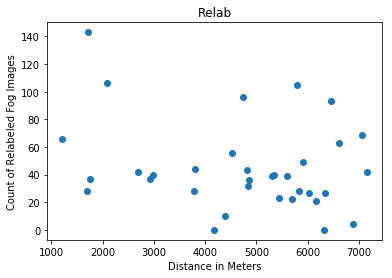

In [58]:
# Scatterplot
plt.scatter(distances, counts)
plt.xlabel('Distance in Meters')
plt.ylabel('Count of Relabeled Fog Images')
plt.title('Relab')
plt.show()

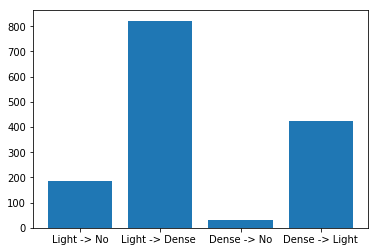

In [112]:
# Barplot
plt.bar(range(len(relabel_dict)), relabel_dict.values(), align='center')
plt.xticks([0, 1, 2, 3], ['Light -> No', 'Light -> Dense ', 'Dense -> No', 'Dense -> Light'])
plt.show()